In [189]:
import tensorflow as tf

In [190]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

Datos de entrenamiento

1. `(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()`: Carga el conjunto de datos MNIST, dividiéndolo en imágenes y etiquetas de entrenamiento. El segundo conjunto (de prueba) no se utiliza, por eso se ignora con `_`.

2. `train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')`: Redimensiona las imágenes de entrenamiento para que tengan un formato de 28x28 píxeles con 1 canal (escala de grises) y convierte los valores a tipo `float32`.

3. `train_images = (train_images - 127.5) / 127.5`: Normaliza los valores de los píxeles, que originalmente están entre 0 y 255, para que queden en el rango [-1, 1]. Esto es importante para mejorar el rendimiento de las redes neuronales, especialmente cuando se usan activaciones como `tanh`, que esperan entradas en este rango.

In [191]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [192]:
BUFFER_SIZE = 1000
BATCH_SIZE = 256

Este código crea un conjunto de datos (`train_dataset`) a partir de las imágenes de entrenamiento (`train_images`). Utiliza la función `from_tensor_slices` para convertir el array de imágenes en un formato compatible con TensorFlow, y luego aplica dos operaciones:

1. `shuffle(BUFFER_SIZE)`: Desordena aleatoriamente las imágenes utilizando un tamaño de buffer especificado por `BUFFER_SIZE`, lo que ayuda a mezclar los datos antes del entrenamiento.
2. `batch(BATCH_SIZE)`: Agrupa las imágenes en lotes del tamaño `BATCH_SIZE`, lo que permite que el modelo entrene en pequeños subconjuntos de datos en cada iteración.

Esto organiza las imágenes de entrenamiento para ser usadas de manera eficiente en el proceso de entrenamiento del modelo.

In [193]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

El generador toma un vector de 100 números aleatorios como entrada y lo transforma en una imagen de 28x28 píxeles. Usa capas densas, BatchNormalizatio), activación LeakyReLU, y varias capas Conv2DTranspose para aumentar el tamaño de la imagen gradualmente hasta obtener la salida final, que tiene una única capa de profundidad y usa la activación tanh para generar la imagen final.

In [194]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 128)))

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model


c:\Users\marka\anaconda3\envs\DataMining11\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


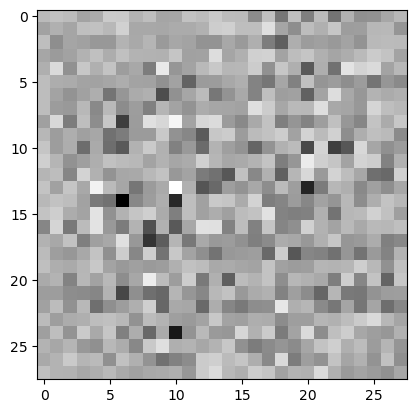

In [195]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

El discriminador toma una imagen de 28x28 píxeles como entrada y la procesa a través de capas convolucionales. Utiliza capas de `Dropout` para prevenir el sobreajuste y reduce la dimensionalidad de la imagen con una capa `Flatten`. Finalmente, una capa densa con una única salida determina si la imagen es real o generada por el modelo, proporcionando una probabilidad.

In [196]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [197]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

c:\Users\marka\anaconda3\envs\DataMining11\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[-0.00276466]], shape=(1, 1), dtype=float32)


In [198]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

1. `real_loss`: Calcula la pérdida del discriminador al clasificar imágenes reales. Compara las salidas del discriminador (`real_output`) con un conjunto de etiquetas de unos (porque las imágenes reales deberían clasificarse como "reales"). Se utiliza la función de pérdida de entropía cruzada (`cross_entropy`) para esta comparación.

2. `fake_loss`: Calcula la pérdida del discriminador al clasificar imágenes generadas (falsas). Compara las salidas del discriminador (`fake_output`) con etiquetas de ceros (porque las imágenes generadas deberían clasificarse como "falsas").

3. `total_loss`: Suma las pérdidas de las imágenes reales y generadas para obtener la pérdida total del discriminador.

El objetivo es minimizar esta pérdida, de modo que el discriminador mejore en clasificar imágenes reales como reales y falsas como falsas.

In [199]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Esta función define la pérdida del generador. El objetivo del generador es crear imágenes falsas que engañen al discriminador haciéndole creer que son reales.

1. `fake_output`: Es la salida del discriminador al clasificar las imágenes generadas por el generador.

2. `cross_entropy(tf.ones_like(fake_output), fake_output)`: Calcula la pérdida del generador comparando las salidas del discriminador (`fake_output`) con un conjunto de etiquetas de unos (porque el generador quiere que el discriminador clasifique las imágenes falsas como "reales"). Se utiliza la función de entropía cruzada para medir qué tan bien está logrando esto.

El generador trata de minimizar esta pérdida, de modo que el discriminador no pueda diferenciar entre las imágenes reales y las generadas.

In [200]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [201]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 8

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

La anotación `@tf.function` optimiza la función compilándola para que sea más rápida.

1. **Generación de ruido**: Se crea un vector de ruido aleatorio con dimensiones `[BATCH_SIZE, noise_dim]` para alimentar al generador.

2. **GradientTape**: `
   - Se utilizan dos tf.GradientTape`, uno para el generador (`gen_tape`) y otro para el discriminador (`disc_tape`). Esto permite calcular los gradientes para ambos modelos.
   
3. **Generación de imágenes**: El generador usa el ruido para generar imágenes falsas (`generated_images`).

4. **Evaluación del discriminador**:
   - `real_output`: El discriminador procesa las imágenes reales y devuelve una clasificación.
   - `fake_output`: El discriminador evalúa las imágenes generadas y también devuelve una clasificación.

5. **Cálculo de pérdidas**:
   - `gen_loss`: Pérdida del generador, basada en qué tan bien las imágenes generadas engañan al discriminador.
   - `disc_loss`: Pérdida del discriminador, basada en su capacidad para diferenciar entre imágenes reales y generadas.

6. **Cálculo de gradientes**:
   - Se calculan los gradientes de la pérdida con respecto a los pesos entrenables del generador y el discriminador.

7. **Actualización de los modelos**:
   - `generator_optimizer.apply_gradients`: Aplica los gradientes calculados para actualizar los pesos del generador.
   - `discriminator_optimizer.apply_gradients`: Hace lo mismo para el discriminador.

En resumen, este bloque realiza un paso completo de entrenamiento, ajustando tanto el generador como el discriminador para que ambos mejoren en sus respectivos objetivos (engañar o no ser engañado).

In [202]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [203]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


1. **Inicio del bucle de épocas**:
   - El entrenamiento se repite por la cantidad de épocas definida en el argumento `epochs`.
   - Al inicio de cada época, se registra el tiempo con `start = time.time()` para medir cuánto tarda cada una.

2. **Entrenamiento por lotes**:
   - Dentro de cada época, se itera sobre cada lote de imágenes del conjunto de datos (`dataset`), llamando a la función `train_step(image_batch)` para entrenar el generador y discriminador en ese lote.

3. **Generación de imágenes**:
   - Se genera y guarda una imagen utilizando la función `generate_and_save_images(generator, epoch + 1, seed)`, donde el generador crea nuevas imágenes a partir de una semilla (`seed`), permitiendo un seguimiento visual del progreso de la GAN.

4. **Medición del tiempo**:
   - Se calcula y muestra el tiempo que tomó completar cada época con `print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))`.

5. **Generación final**:
   - Después de la última época, se genera una imagen final con el mismo método de visualización.

En resumen, esta función coordina el entrenamiento de la GAN durante múltiples épocas, mide el tiempo por cada una y genera imágenes en cada iteración para ver cómo mejora la calidad de las imágenes generadas.

In [204]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    gen_losses = []
    disc_losses = []

    for image_batch in dataset:
        gen_loss, disc_loss = train_step(image_batch)
        gen_losses.append(gen_loss.numpy())
        disc_losses.append(disc_loss.numpy())

    # Produce images for the GIF as you go
    # display.clear_output(wait=True)
    # generate_and_save_images(generator, epoch + 1, seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
    # Save the model every 15 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)


        # Generate after the final epoch
        # display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, seed)

        plt.figure(figsize=(10, 5))
        plt.plot(gen_losses, label='Pérdida del generador')
        plt.plot(disc_losses, label='Pérdida del discriminador')
        plt.xlabel(f"Paso de entrenamiento {epoch}")
        plt.ylabel('Pérdida')
        plt.legend()
        plt.show()


Time for epoch 1 is 11.536636352539062 sec
Time for epoch 2 is 9.161875247955322 sec
Time for epoch 3 is 9.165958404541016 sec
Time for epoch 4 is 9.293023109436035 sec
Time for epoch 5 is 9.278446435928345 sec


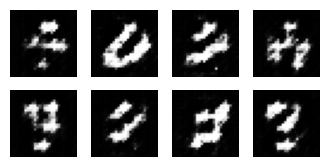

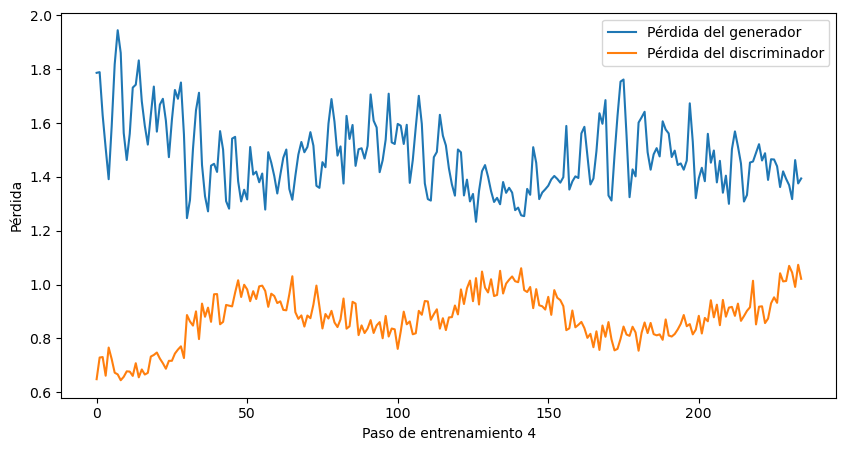

Time for epoch 6 is 9.819298505783081 sec
Time for epoch 7 is 9.47633957862854 sec
Time for epoch 8 is 9.575109720230103 sec
Time for epoch 9 is 9.382197856903076 sec
Time for epoch 10 is 9.432143688201904 sec


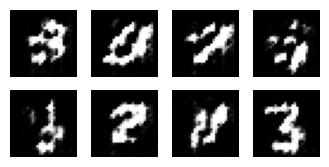

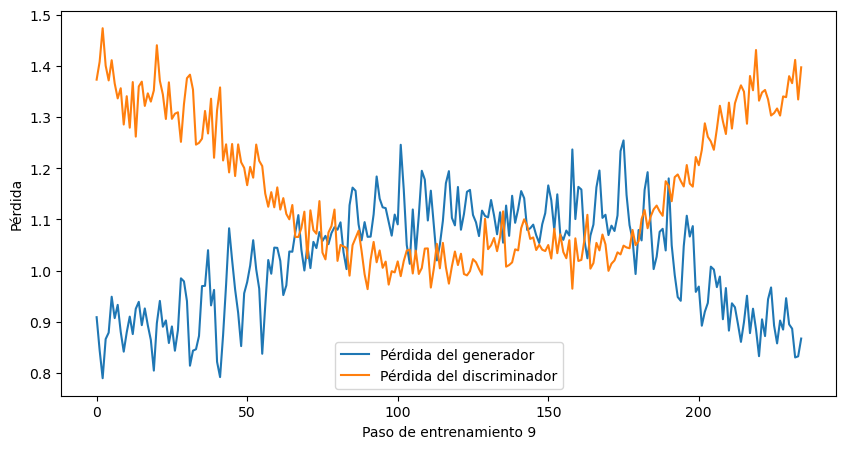

Time for epoch 11 is 9.818458080291748 sec
Time for epoch 12 is 9.427990913391113 sec
Time for epoch 13 is 9.29770302772522 sec
Time for epoch 14 is 9.376323699951172 sec
Time for epoch 15 is 9.125535488128662 sec


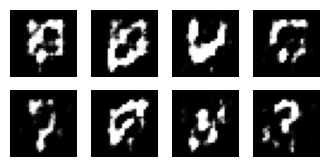

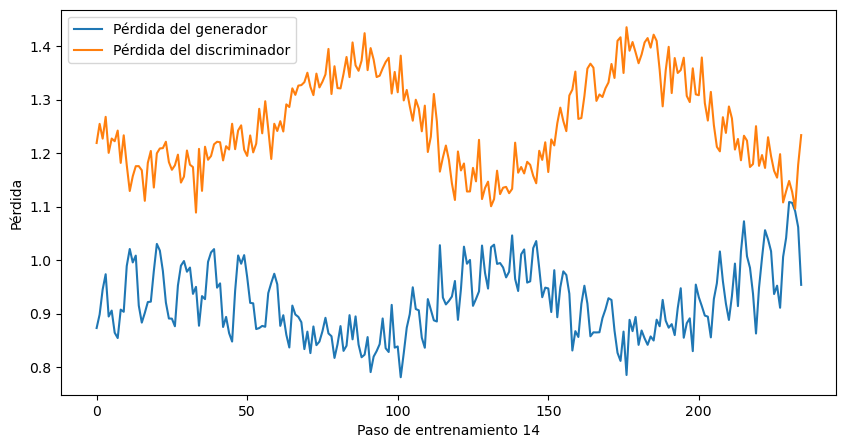

Time for epoch 16 is 9.579308271408081 sec
Time for epoch 17 is 9.490915536880493 sec
Time for epoch 18 is 9.24807071685791 sec
Time for epoch 19 is 9.175127029418945 sec
Time for epoch 20 is 9.81702971458435 sec


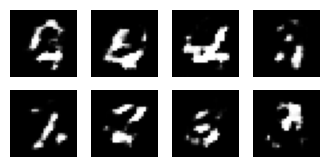

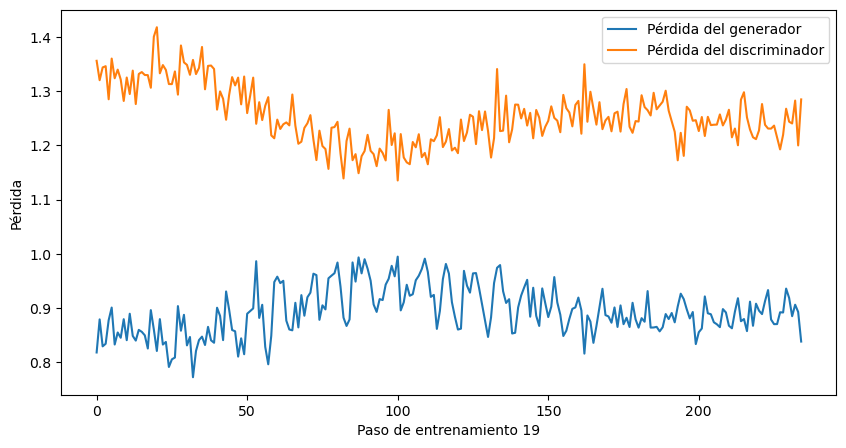

Time for epoch 21 is 9.43331241607666 sec
Time for epoch 22 is 9.130062818527222 sec
Time for epoch 23 is 9.184850454330444 sec
Time for epoch 24 is 9.138354063034058 sec
Time for epoch 25 is 9.129549026489258 sec


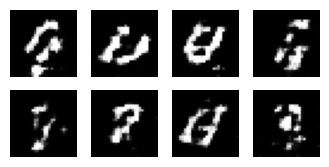

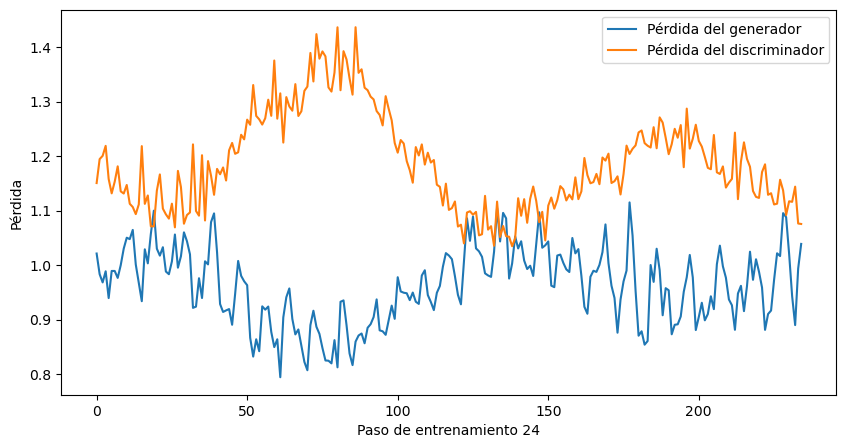

Time for epoch 26 is 9.476043224334717 sec
Time for epoch 27 is 9.90799880027771 sec
Time for epoch 28 is 9.438851118087769 sec
Time for epoch 29 is 9.329135179519653 sec
Time for epoch 30 is 9.219281911849976 sec


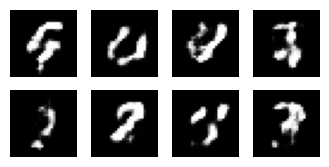

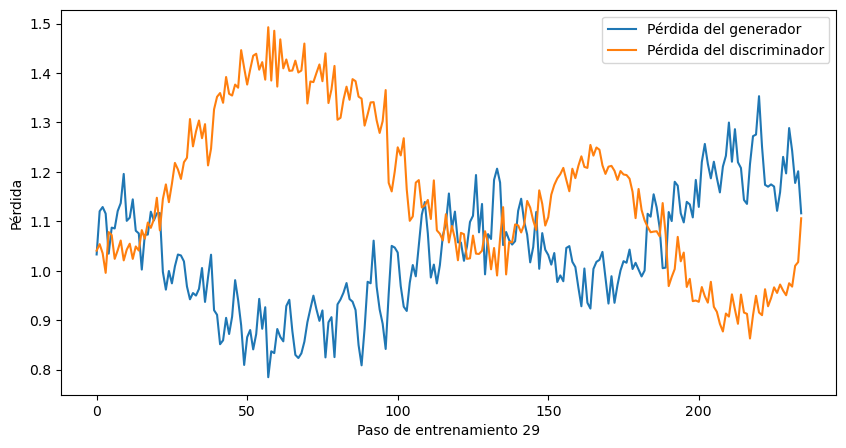

Time for epoch 31 is 9.181640386581421 sec
Time for epoch 32 is 9.160954475402832 sec
Time for epoch 33 is 9.15239143371582 sec
Time for epoch 34 is 9.113238334655762 sec
Time for epoch 35 is 9.096667766571045 sec


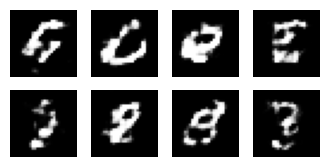

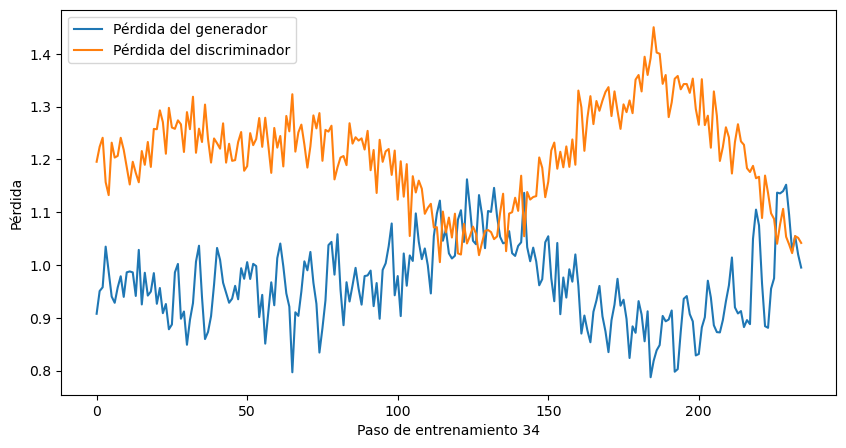

Time for epoch 36 is 9.091121912002563 sec
Time for epoch 37 is 9.14038634300232 sec
Time for epoch 38 is 9.955092906951904 sec
Time for epoch 39 is 10.664090633392334 sec
Time for epoch 40 is 10.734202146530151 sec


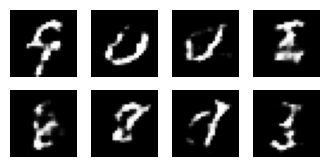

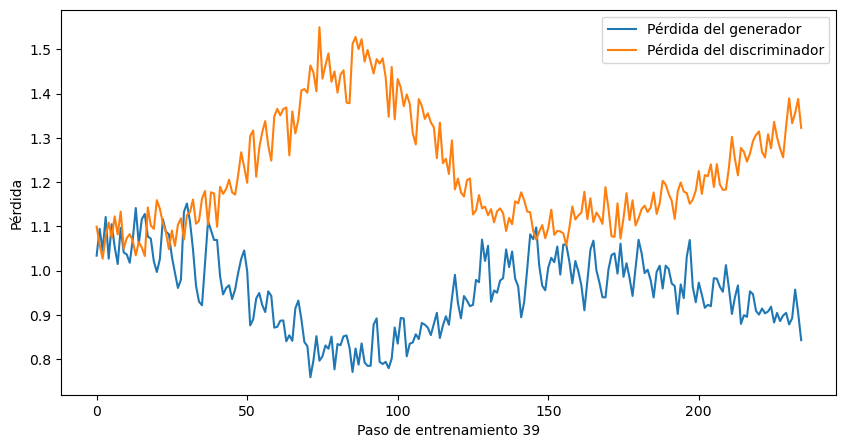

Time for epoch 41 is 9.483376026153564 sec
Time for epoch 42 is 9.614518880844116 sec
Time for epoch 43 is 9.444001197814941 sec
Time for epoch 44 is 9.829819202423096 sec
Time for epoch 45 is 9.657607555389404 sec


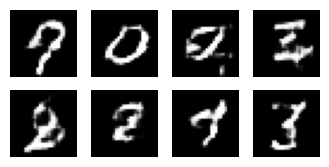

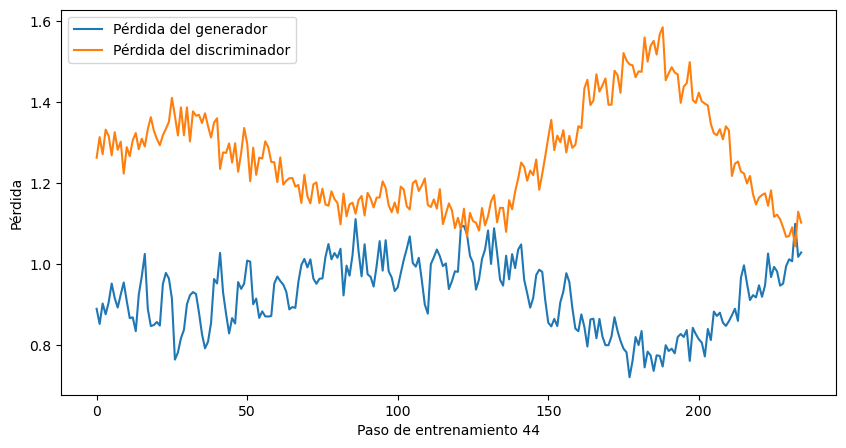

Time for epoch 46 is 9.95194673538208 sec
Time for epoch 47 is 9.441205024719238 sec
Time for epoch 48 is 9.516236305236816 sec
Time for epoch 49 is 9.288143873214722 sec
Time for epoch 50 is 9.365448236465454 sec


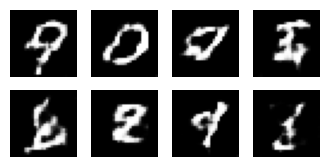

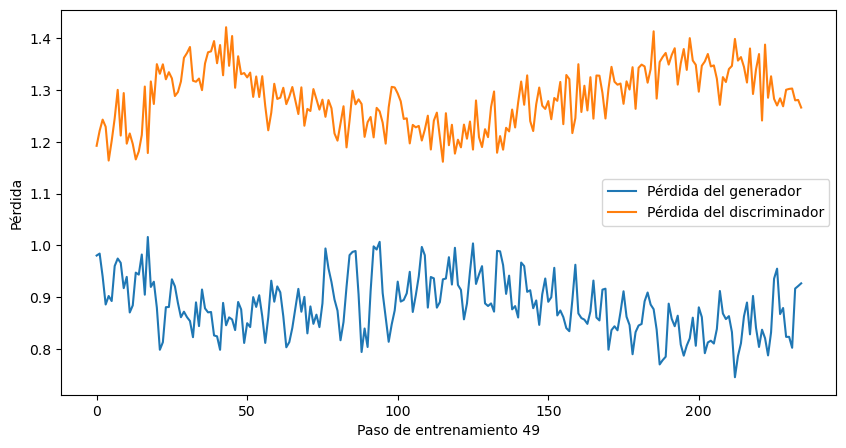

Time for epoch 51 is 9.355210065841675 sec
Time for epoch 52 is 9.377303123474121 sec
Time for epoch 53 is 9.204775094985962 sec
Time for epoch 54 is 9.184157609939575 sec
Time for epoch 55 is 9.211843967437744 sec


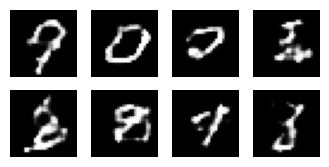

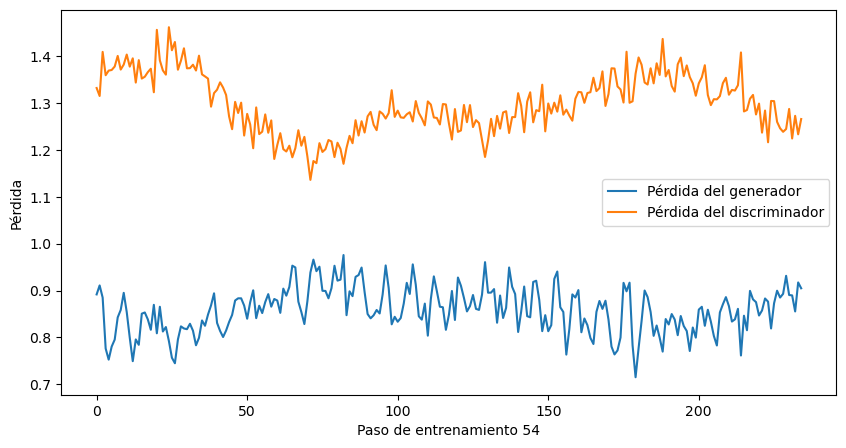

Time for epoch 56 is 9.191314697265625 sec
Time for epoch 57 is 9.211270809173584 sec
Time for epoch 58 is 9.310185432434082 sec
Time for epoch 59 is 9.172090768814087 sec
Time for epoch 60 is 9.193324089050293 sec


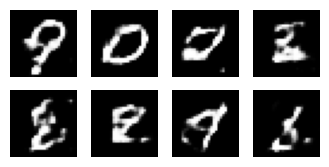

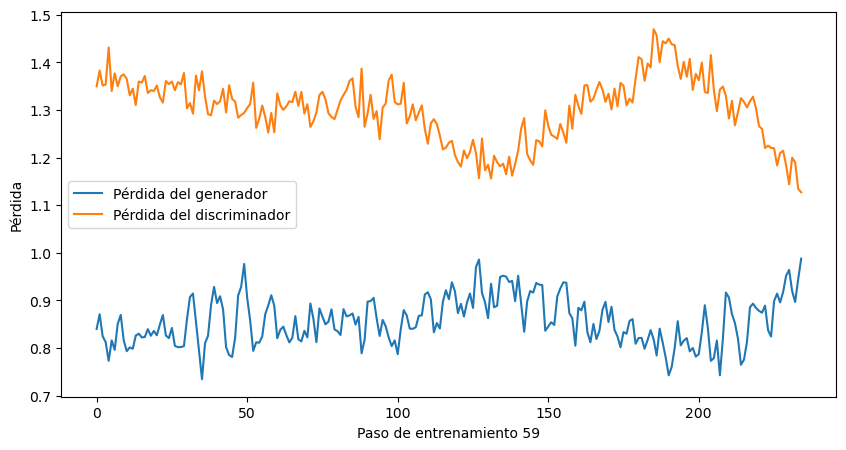

Time for epoch 61 is 9.361692905426025 sec
Time for epoch 62 is 9.806170225143433 sec
Time for epoch 63 is 9.559343338012695 sec
Time for epoch 64 is 9.302895545959473 sec
Time for epoch 65 is 9.230429649353027 sec


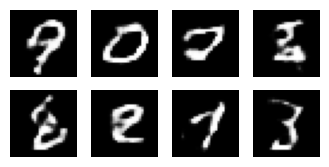

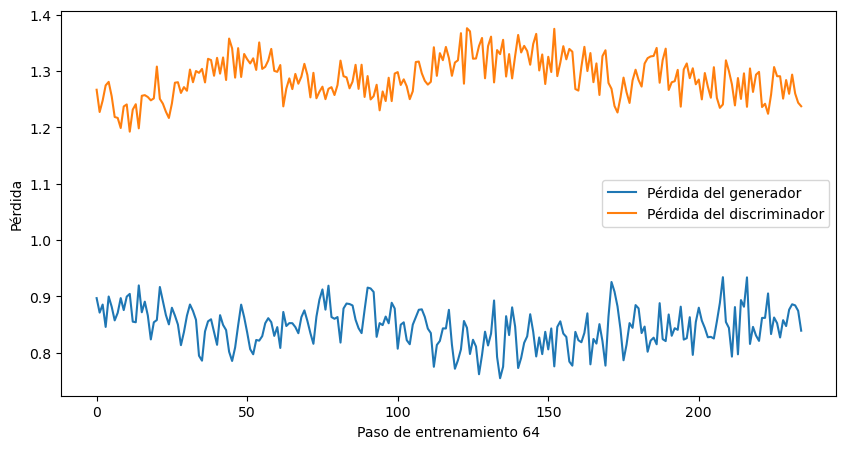

Time for epoch 66 is 9.300820589065552 sec
Time for epoch 67 is 9.805638313293457 sec
Time for epoch 68 is 9.403546810150146 sec
Time for epoch 69 is 9.48704743385315 sec
Time for epoch 70 is 9.355889558792114 sec


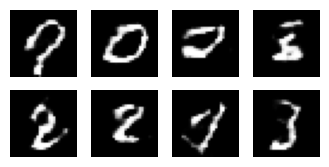

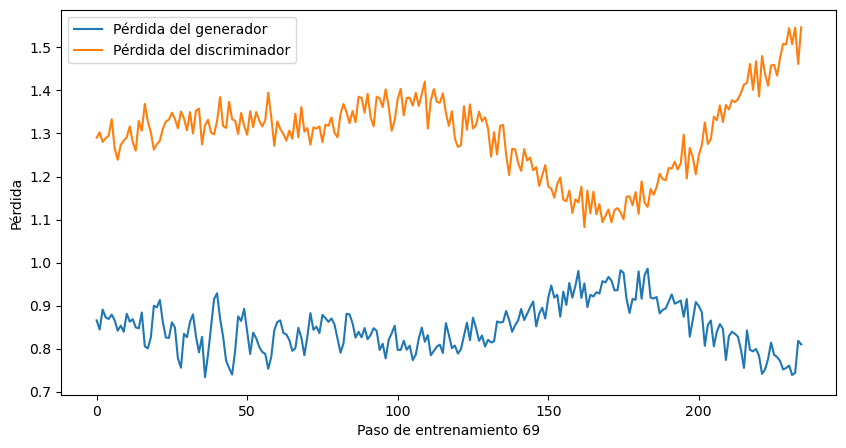

Time for epoch 71 is 9.288240909576416 sec
Time for epoch 72 is 9.346350193023682 sec
Time for epoch 73 is 9.067627668380737 sec
Time for epoch 74 is 9.07634162902832 sec
Time for epoch 75 is 9.092368841171265 sec


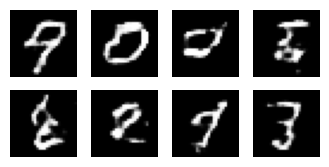

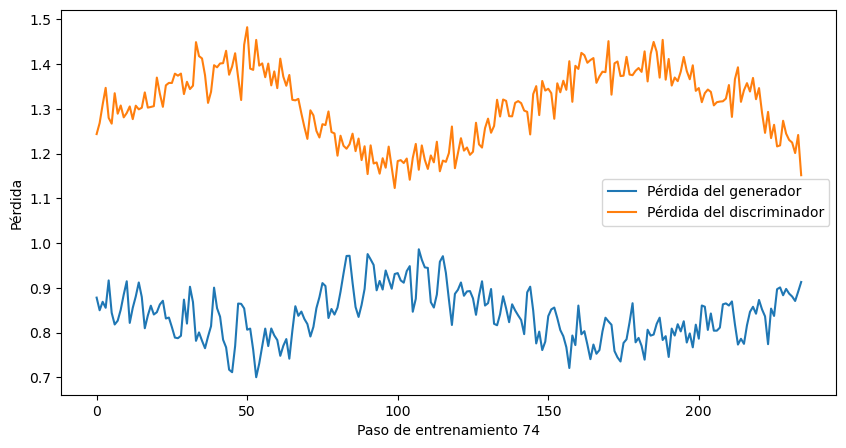

Time for epoch 76 is 9.914555311203003 sec
Time for epoch 77 is 9.651801109313965 sec
Time for epoch 78 is 9.771769762039185 sec
Time for epoch 79 is 9.936198711395264 sec
Time for epoch 80 is 9.143631219863892 sec


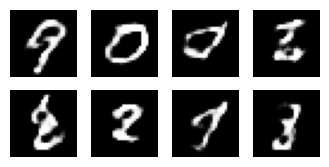

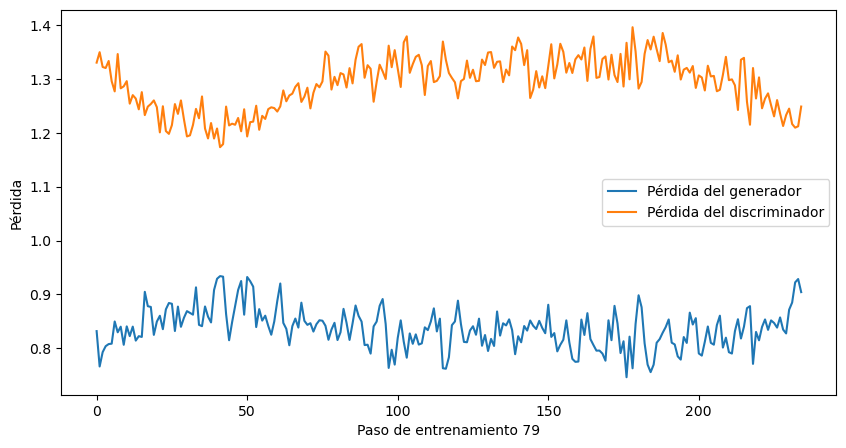

Time for epoch 81 is 9.284634590148926 sec
Time for epoch 82 is 9.25812292098999 sec
Time for epoch 83 is 10.585259199142456 sec
Time for epoch 84 is 10.426774501800537 sec
Time for epoch 85 is 9.366865396499634 sec


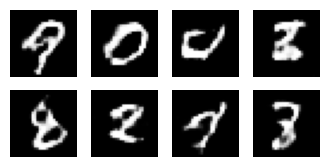

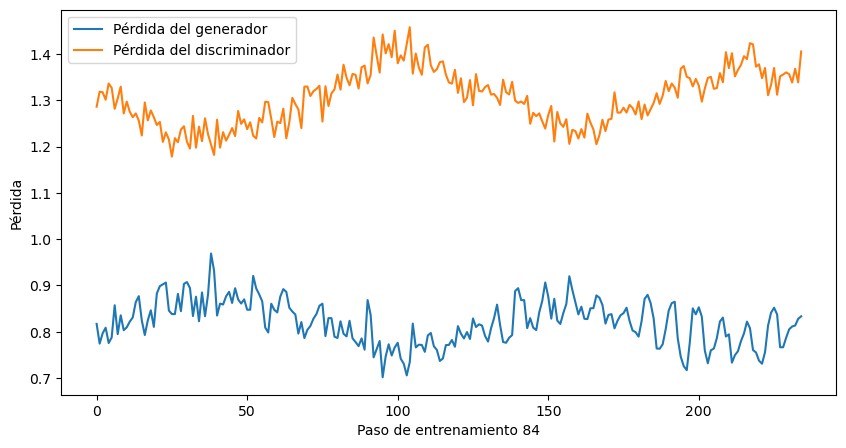

Time for epoch 86 is 9.284486770629883 sec
Time for epoch 87 is 9.333706617355347 sec
Time for epoch 88 is 9.28299331665039 sec
Time for epoch 89 is 9.395862579345703 sec
Time for epoch 90 is 9.44245433807373 sec


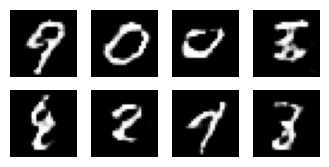

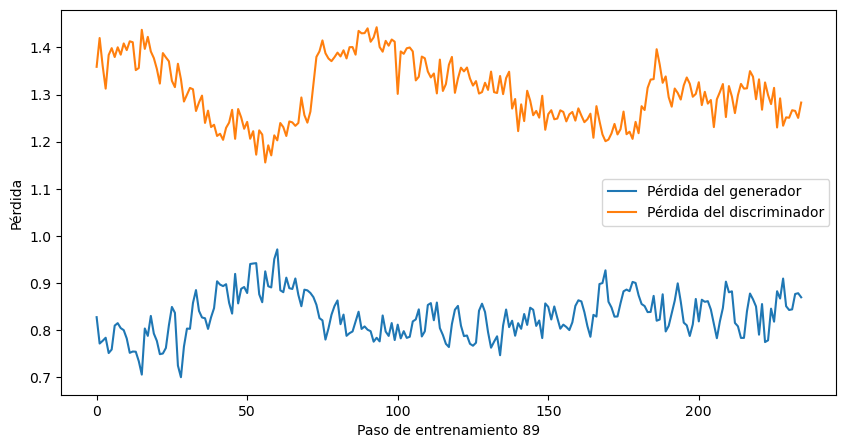

Time for epoch 91 is 9.70796799659729 sec
Time for epoch 92 is 9.461722135543823 sec
Time for epoch 93 is 9.236446380615234 sec
Time for epoch 94 is 9.095897674560547 sec
Time for epoch 95 is 9.049768686294556 sec


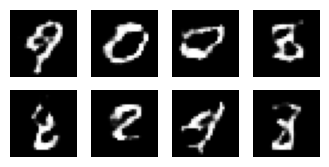

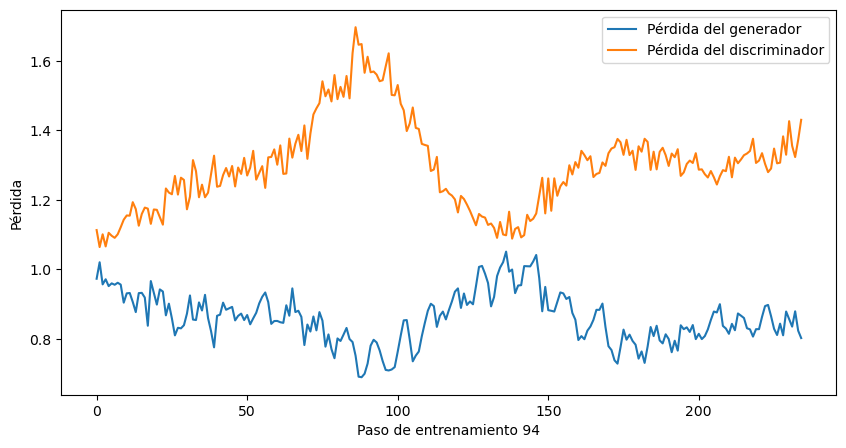

Time for epoch 96 is 9.049707651138306 sec
Time for epoch 97 is 9.046698570251465 sec
Time for epoch 98 is 9.022212982177734 sec
Time for epoch 99 is 9.08490514755249 sec
Time for epoch 100 is 9.212738037109375 sec


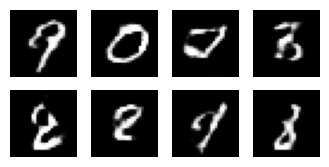

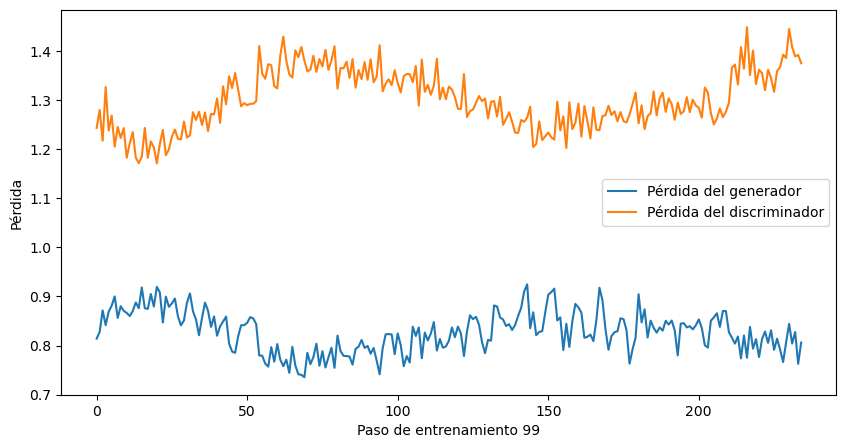

In [205]:
train(train_dataset, EPOCHS)

# with tf.device('/device:GPU:0'):
#     train(train_dataset, EPOCHS)